##Hyperparameters for the model:

In [ ]:
epoch_num = 500 #Number of epochs
learning_rate = 0.0005
hidden_feat_num = 20
batch_size = 1
lang_list = range(40,60) #eventually make it to 124...
token_per_type = 1

#Dictionary that maps from feature values in the SR to segments:
feats2symbol_sr = {
                      "1,1,1":"1",
                      "1,1,-1":"2",
                      "1,-1,-1":"0",
                      "-1,-1,-1":"E" 
                  }

#Mount the user's google drive:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


##Install and import the necessary packages:

In [ ]:
#CD into our google drive so we can use the custom Seq2Seq package
%cd gdrive/My Drive
import Seq2Seq

#Import everything else:
import numpy as np
from re import sub
from tensorflow.keras import backend
from random import choice, shuffle
from itertools import product
from matplotlib.pyplot import plot
from IPython.display import clear_output


/content/gdrive/My Drive


##Functions for processing the training data

In [ ]:
def get_strings(input_fn, copies=1):
  input_file = open("/content/gdrive/My Drive/NN_Stress/Input_Files/"+input_fn)
  input_file.readline()
  UR_strings = []
  SR_strings = []
  syll_lengths = []
  for line in input_file.readlines():
    columns = line.split(",")
    if len(columns) == 1:
      raw_ur = line.rstrip() 
    if len(columns) == 3:
      raw_sr = columns[1]
      raw_p = columns[2]
      ur, sr, p = sub("\"|\[|\]", "", raw_ur), sub("\[|\]", "", raw_sr), raw_p.rstrip()
      if p == "1":
        syll_lengths.append(len(ur.split(" ")))
        UR_strings.append(ur)
        new_sr = []
        for syll in sr.split(" "):
          new_syll = {"L1":"1", "H1":"1", "L2":"2", "H2":"2", "L":"0", "H":"0"}[syll]
          new_sr.append(new_syll)
        SR_strings.append(" ".join(new_sr))

  if copies > 1:
    lexical_labels = [c for c in range(1,1+(copies*len(UR_strings)))]
    shuffle(lexical_labels)
    token_UR_strings = []
    token_SR_strings = []
    token_syll_lengths = []
    for i, ur in enumerate(UR_strings):
      sr = SR_strings[i]
      for copy in range(copies):
        this_label = str(lexical_labels.pop())
        token_UR_strings.append(ur+"_"+this_label)
        token_SR_strings.append(sr)
        token_syll_lengths.append(syll_lengths[i])
    return token_UR_strings, token_SR_strings, token_syll_lengths

  return UR_strings, SR_strings, syll_lengths

def get_arrays(UR_strings, SR_strings, syll_lengths):
  symbol2feats_ur = {
                  #Syll	#Heavy
              "L":[	1.,		-1.],
              "H":[	1.,		1.],
              "E":[	-1.,		-1.]
            }
  symbol2feats_sr = {}
  for feat_bundle in feats2symbol_sr.keys():
    these_feats = [float(f) for f in feat_bundle.split(",")]
    symbol2feats_sr[feats2symbol_sr[feat_bundle]] = these_feats

  if "_" in "".join(UR_strings):
    #If we're using lexical features:
    real_strings = []
    raw_lex_nums = []
    max_lexLen = -1
    ur_pieces = ur.split("_")
    if len(ur_pieces) > 1:
      real_string, lex_num = ur_pieces
      bin_lex_num = str(bin(int(lex_num)).replace("0b", ""))
      raw_lex_nums.append(bin_lex_num)
      if len(bin_lex_num) > max_lexLen:
        max_lexLen = len(bin_lex_num)
    else:
      real_string = ur
    real_strings.append(real_string)

    lex_nums = []
    for ln in raw_lex_nums:
      zeros = "0" * (max_lexLen - len(ln))
      lex_nums.append([float(digit) for digit in zeros+ln])

    max_len = max(syll_lengths)
    X_list = []
    Y_list = []
    for word_index, syll_length in enumerate(syll_lengths):
      padding = " ".join(["E"]*(max_len-syll_length))
      this_length = len(real_strings[word_index].split(" "))
      this_ur = real_strings[word_index]+" "+padding
      this_sr = SR_strings[word_index]+" "+padding
      if len(lex_nums) > 0:
        X_list.append([symbol2feats_ur[seg]+lex_nums[word_index] for seg in this_ur.split(" ") if seg != ""])
      else:
        X_list.append([symbol2feats_ur[seg] for seg in this_ur.split(" ") if seg != ""])
      Y_list.append([symbol2feats_sr[seg] for seg in this_sr.split(" ") if seg != ""])
  else:
    max_len = max(syll_lengths)
    X_list = []
    Y_list = []
    for word_index, syll_length in enumerate(syll_lengths):
      padding = " ".join(["E"]*(max_len-syll_length))
      this_length = len(UR_strings[word_index].split(" "))
      this_ur = UR_strings[word_index]+" "+padding
      this_sr = SR_strings[word_index]+" "+padding
      X_list.append([symbol2feats_ur[seg] for seg in this_ur.split(" ") if seg != ""])
      Y_list.append([symbol2feats_sr[seg] for seg in this_sr.split(" ") if seg != ""])

  X = np.array(X_list)
  Y = np.array(Y_list)

  return X, Y


def get_test_arrays (UR_strings, syll_lengths):
  symbol2feats_ur = {
                #Syll	#Heavy
            "L":[	1.,		-1.],
            "H":[	1.,		1.],
            "E":[	-1.,		-1.]
          }
  real_strings = []
  raw_lex_nums = []
  max_lexLen = -1
  for ur in UR_strings:
    ur_pieces = ur.split("_")
    if len(ur_pieces) > 1:
      real_string, lex_num = ur_pieces
      bin_lex_num = str(bin(int(lex_num)).replace("0b", ""))
      raw_lex_nums.append(bin_lex_num)
      if len(bin_lex_num) > max_lexLen:
        max_lexLen = len(bin_lex_num)
    else:
      real_string = ur
    real_strings.append(real_string)

  lex_nums = []
  for ln in raw_lex_nums:
    zeros = "0" * (max_lexLen - len(ln))
    lex_nums.append([0.0 for digit in zeros+ln]) #All zeroes for lexical features, b/c test data are nonce words

  max_len = max(syll_lengths)
  X_list = []
  for word_index, syll_length in enumerate(syll_lengths):
    padding = " ".join(["E"]*(max_len-syll_length))
    this_length = len(real_strings[word_index].split(" "))
    this_ur = real_strings[word_index]+" "+padding
    if len(lex_nums) > 0:
      X_list.append([symbol2feats_ur[seg]+lex_nums[word_index] for seg in this_ur.split(" ") if seg != ""])
    else:
      X_list.append([symbol2feats_ur[seg] for seg in this_ur.split(" ") if seg != ""])

  return np.array(X_list)

##Run the simulations

In [ ]:
learning_curves = []
lang2results = {l:{} for l in lang_list}
lang2testResults = {l:{} for l in lang_list}
lang2acc = {l:0 for l in lang_list}
lang2SRs = {}
for l in lang_list:
  print ("Language", l)

  #Load the training data:
  file_name = "ts"+str(l)+".csv"
  URs, SRs, Ls = get_strings(file_name, token_per_type)

  lang2SRs[l] = SRs

  X, Y = get_arrays(URs, SRs, Ls)
  test_X = get_test_arrays(URs, Ls)
  lang2results[l] = {ur:"" for ur in URs}
  lang2testResults[l] = {sub("_.+", "", ur):"" for ur in URs}

  #Build the model:
  model = Seq2Seq.seq2seq(
                              input_dim=X.shape[2],
                              hidden_dim=hidden_feat_num,
                              output_length=Y.shape[1],
                              output_dim=Y.shape[2],
                              batch_size=batch_size,
                              learn_rate=learning_rate
                            )
	
  #Train the model:
  hist = model.train(
                        X, Y,
                        epoch_num=epoch_num,
                        print_every=10
                     )
  
  #Save the useful info and delete everything else:
  #Training data performance:
  learning_curves.append(hist["Loss"])
  Y_hat = model.predict(X)
  accs_by_word = []
  for i, word in enumerate(Y_hat):
    word_list = []
    for seg in word:
      feat_strings = []
      for feat in seg:
        if feat < 0.0:
          feat_strings.append("-1")
        elif feat > 0.0:
          feat_strings.append("1")
        else:
          raise Exception("Feature value of zero in output!")
      bundle_string = ",".join(feat_strings)
      if bundle_string in feats2symbol_sr.keys():
        seg_string = feats2symbol_sr[bundle_string]
      else:
        seg_string = "?"
      if seg_string != "E":
        word_list.append(seg_string)
    word_string = " ".join(word_list)
    if word_string == SRs[i]:
      accs_by_word.append(1.0) 
    else:
      accs_by_word.append(0.0) 
    lang2results[l][URs[i]] = word_string
  lang2acc[l] = np.mean(accs_by_word)

  #Test data performance
  test_predictions = model.predict(test_X)
  urs_so_far = []
  for i, word in enumerate(test_predictions):
    bare_ur = sub("_.+", "", URs[i])
    if bare_ur in urs_so_far:
      continue
    urs_so_far.append(bare_ur)  
    word_list = []
    for seg in word:
      feat_strings = []
      for feat in seg:
        if feat < 0.0:
          feat_strings.append("-1")
        elif feat > 0.0:
          feat_strings.append("1")
        else:
          raise Exception("Feature value of zero in output!")
      bundle_string = ",".join(feat_strings)
      if bundle_string in feats2symbol_sr.keys():
        seg_string = feats2symbol_sr[bundle_string]
      else:
        seg_string = "?"
      if seg_string != "E":
        word_list.append(seg_string) 
    word_string = " ".join(word_list)
    if word_string == SRs[i]:
      accs_by_word.append(1.0) 
    else:
      accs_by_word.append(0.0) 

    lang2testResults[l][bare_ur] = word_string

  backend.clear_session()
  clear_output()

##Plot and save the results:

In [ ]:
l2ur2sr = {l:{} for l in lang_list}
for l in lang_list:
  SRs = lang2SRs[l]
  for raw_ur, sr in zip(URs,SRs):
    ur = sub("_.+", "", raw_ur)
    l2ur2sr[l][ur] = sr

for l in lang_list:
  type_acc = {}
  output_file = open("/content/gdrive/My Drive/NN_Stress/Output_Files/"+str(l)+"_token_output.csv", "w")
  output_file.write("UR,Correct_SR,Predicted_SR\n")
  for ur in lang2results[l].keys():
    type_ur = sub("_.+", "", ur)
    this_sr = l2ur2sr[l][type_ur]
    if type_ur in type_acc.keys():
      type_acc[type_ur].append(int(lang2results[l][ur]==this_sr))
    else:
      type_acc[type_ur] = [int(lang2results[l][ur]==this_sr)]
    output_file.write(",".join([ur, this_sr, lang2results[l][ur]])+"\n")
  output_file.close()

  type_output_f = open("/content/gdrive/My Drive/NN_Stress/Output_Files/"+str(l)+"_type_output.csv", "w")
  type_output_f.write("UR-Type,Accuracy\n")
  for ur in type_acc.keys():
    type_output_f.write(ur+","+str(np.mean(type_acc[ur]))+"\n")
  type_output_f.close()

  test_output_f = open("/content/gdrive/My Drive/NN_Stress/Output_Files/"+str(l)+"_test_output.csv", "w")
  test_output_f.write("Test-UR,Correct-SR,Predicted-SR,Accuracy\n")
  urs_so_far = []
  for ur in lang2testResults[l].keys():
    bare_ur = sub("_.+", "", ur)
    if bare_ur in urs_so_far:
      continue
    this_sr = l2ur2sr[l][bare_ur]
    urs_so_far.append(bare_ur)
    test_output_f.write(",".join([bare_ur, this_sr, lang2testResults[l][ur], str(int(this_sr==lang2testResults[l][ur]))])+"\n")
  test_output_f.close()   

success_file = open("/content/gdrive/My Drive/NN_Stress/Output_Files/"+str(lang_list[0])+"-"+str(lang_list[-1])+"_accuracies.csv", "w")
success_file.write("Language,Accuracy\n")
for l in lang2acc.keys():
  success_file.write(str(l)+","+str(lang2acc[l])+"\n")
success_file.close() 

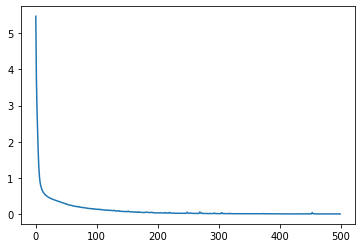

In [ ]:
av_curve = np.mean(learning_curves, axis=0)
plot(av_curve) 